In [84]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

<h1>PREPARING DATA</h1>

<h4>0. Input Data</h4>

In [85]:
df = pd.read_excel('input\Class_EK.xlsx')
df.head()

,MQ2,MQ3,MQ4,MQ5,MQ6,MQ7,MQ8,MQ9,MQ135,SPAD,Nitrogen,Flavonoid
0,0.264575,0.374166,0.824621,0.34641,0.141421,0.141421,0.34641,0.4,0.1,38.6,Deficient,Deficient
1,0.264575,0.374166,0.842615,0.34641,0.141421,0.100000,0.34641,0.4,0.1,37.9,Deficient,Deficient
2,0.264575,0.374166,0.854400,0.34641,0.100000,0.100000,0.34641,0.4,0.1,41.4,Deficient,Deficient
3,0.282843,0.374166,0.854400,0.34641,0.141421,0.100000,0.34641,0.4,0.1,41.8,Deficient,Deficient
4,0.264575,0.374166,0.836660,0.34641,0.141421,0.100000,0.34641,0.4,0.1,41.7,Deficient,Deficient


In [86]:
df.drop(['Nitrogen','MQ5', 'MQ9', 'SPAD'], axis=1, inplace=True)

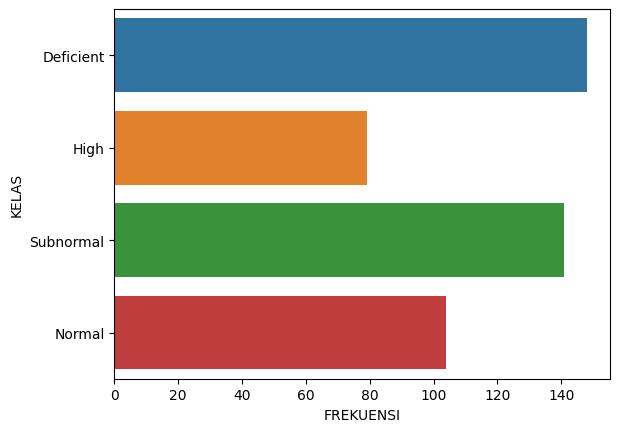

In [87]:
sns.countplot(y=df.Flavonoid, data=df)
plt.xlabel("FREKUENSI")
plt.ylabel("KELAS")
plt.show()

<h4>1. Membagi Data untuk Training dan Testing</h4>

In [88]:
X = df.drop(['Flavonoid'], axis=1)
y = df.Flavonoid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

<h4>2. Standarisasi Data</h4>

In [89]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


<h1>METODE 1: KNN</h1>

In [90]:
from sklearn.neighbors import KNeighborsClassifier

<h4>1. Menentukan Nilai k</h4>


The optimal number of neighbors is 3.


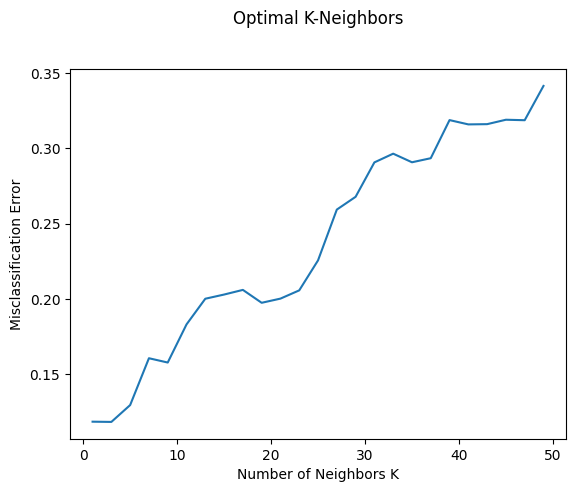

In [91]:
myList = list(range(0, 50))
neighbors = list(filter(lambda x : x % 2 != 0, myList))
neighbors
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy' )
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)
plt.title('Optimal K-Neighbors', y=1.1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

<h4>2. Tune KNN</h4>

In [92]:
clf = KNeighborsClassifier(metric= 'euclidean', n_neighbors= optimal_k)
clf.fit(X_train, y_train)

y_pred_knn = clf.predict(X_test)
pd.crosstab(y_test, y_pred_knn)

cm = confusion_matrix(y_test, y_pred_knn)
accuracy_KNN = accuracy_score(y_test, y_pred_knn)*100



<h1>METODE 2 : SVM</h1>

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from transformers import pipeline

<h4>1. Menentukan Parameter Terbaik</h4>

In [94]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    }

gridSearch = GridSearchCV(SVC(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s


[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...................

<h4>2. Tune SVM</h4>

In [95]:
svm = make_pipeline(StandardScaler(), SVC(gamma='scale', kernel='linear'))
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
pd.crosstab(y_test, y_pred_svm)

cm = confusion_matrix(y_test, y_pred_svm)
accuracy_SVM = accuracy_score(y_test, y_pred_svm)*100



<h1>METODE 3: Decission Trees (dt)</h1>

In [96]:
from sklearn.tree import DecisionTreeClassifier

<h4>1. Menentukan Parameter Terbaik</h4>

In [97]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    }

gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END ..................................criterion=entropy; total time=   0.0s
[CV] END ..................................crite

<h4>2. Tune DT</h4>

In [98]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
pd.crosstab(y_test, y_pred_dt)

cm = confusion_matrix(y_test, y_pred_dt)
accuracy_DTC = accuracy_score(y_test, y_pred_dt)*100



<h4>>>>> Visualisasi</h4>

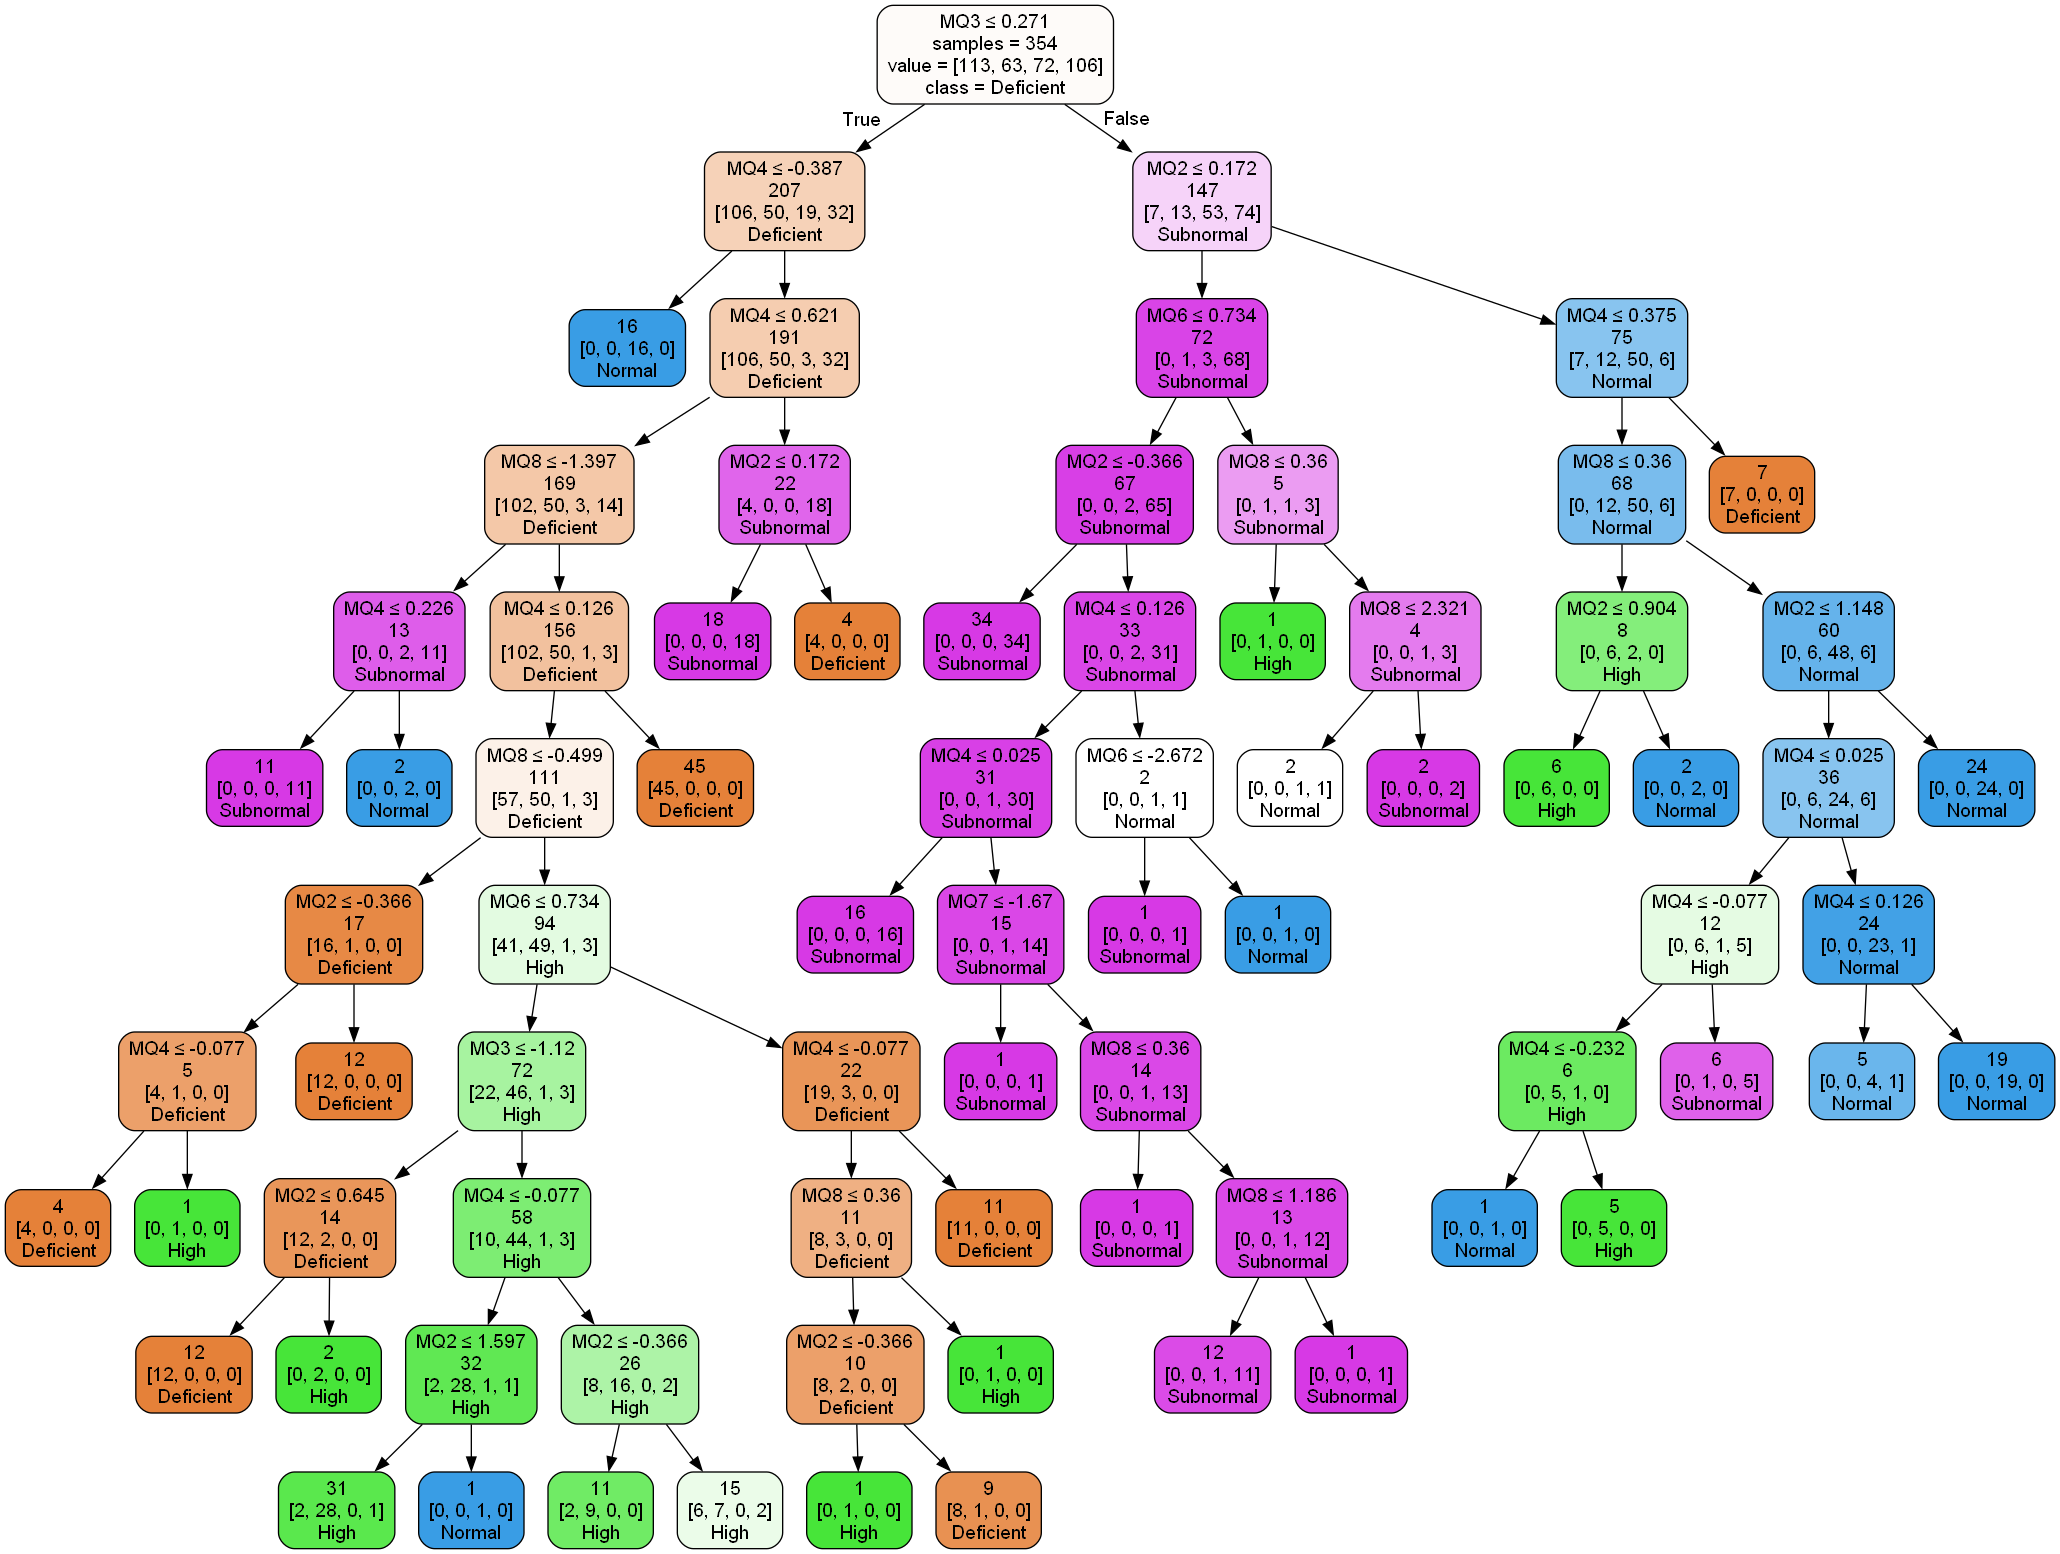

In [99]:
from dmba import plotDecisionTree
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

plotDecisionTree(dt, feature_names=X_train.columns, class_names=dt.classes_)

<h4>1. Preprocessing</h4>

<h1>METODE 4: Multilayer Perceptron (mlp)</h1>

In [100]:
from sklearn.neural_network import MLPClassifier

<h4>1. Menentukan parameter terbaik</h4>

In [101]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8)

param_grid = {
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam']
    }

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.1s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.1s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.1s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.1s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ....................activation=identity, solver=sgd; total time=   0.7s
[CV] END ....................activation=identi

<h4>2. Tune MLP</h4>

In [102]:
mlp = MLPClassifier(hidden_layer_sizes=10,activation='identity', solver='lbfgs', max_iter=1000,
                            random_state=8)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_mlp)
accuracy_MLP = accuracy_score(y_test, y_pred_mlp)*100


<h1>COMPARING METHODE</h1>

In [103]:
print("----------------------------MLP-----------------------------------------")
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_mlp, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_mlp, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_mlp, average='macro')))

print("----------------------------DT-----------------------------------------")
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_dt, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_dt, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_dt, average='macro')))

print("----------------------------SVM-----------------------------------------")
print(classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_svm, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_svm, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_svm, average='macro')))

print("----------------------------KNN-----------------------------------------")
print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_knn, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_knn, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_knn, average='macro')))

print("----------------------------Akurasi-----------------------------------------")
print("Accuracy with K-NN: {0:.2f}%".format(accuracy_KNN))
print("Accuracy with SVM: {0:.2f}%".format(accuracy_SVM))
print("Accuracy with DTC: {0:.2f}%".format(accuracy_DTC))
print("Accuracy with MLP: {0:.2f}%".format(accuracy_MLP))

----------------------------MLP-----------------------------------------
              precision    recall  f1-score   support

   Deficient       0.91      0.83      0.87        35
        High       0.47      0.44      0.45        16
      Normal       0.71      0.53      0.61        32
   Subnormal       0.70      0.94      0.80        35

    accuracy                           0.73       118
   macro avg       0.70      0.69      0.68       118
weighted avg       0.73      0.73      0.72       118

Recall:0.69
Precision:0.70
F1-Score:0.68
----------------------------DT-----------------------------------------
              precision    recall  f1-score   support

   Deficient       0.97      0.94      0.96        35
        High       0.80      1.00      0.89        16
      Normal       1.00      0.97      0.98        32
   Subnormal       0.97      0.91      0.94        35

    accuracy                           0.95       118
   macro avg       0.94      0.96      0.94       118

Text(0.5, 53.92963972600329, 'PREDIKSI')

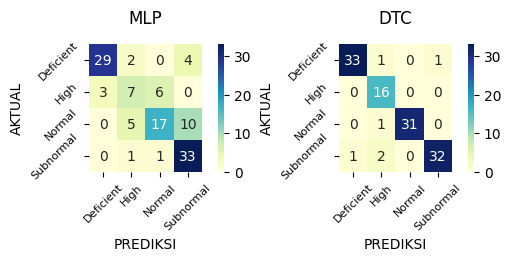

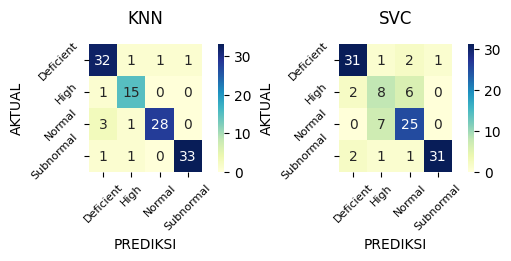

In [104]:
plt.figure(figsize=(5,2.5), layout="constrained")
plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_mlp), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('MLP', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_dt), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('DTC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')


plt.figure(figsize=(5,2.5), layout="constrained")
plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_knn), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('KNN', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_svm), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('SVC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

Text(0.5, -1.777777777777784, 'PREDIKSI')

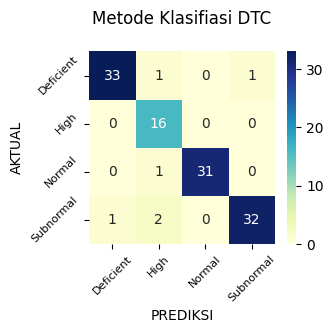

In [105]:
plt.figure(figsize=(3,2.5))
p = sns.heatmap(pd.crosstab(y_test, y_pred_dt), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('Metode Klasifiasi DTC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')